#### Yusif Hajizade CS-020 id: 22022735

# **Computer Vision Final Project.**
# **Handwritten Digit Recognition**

### **Abstract:**

Handwritten digit recognition is a fundamental problem in the field of computer vision and pattern recognition. This project aims to accurately identify handwritten digits in images and overlay them back onto the original image. The approach involves preprocessing the image using OpenCV, extracting digits, and training a model using custom handwritten datasets and the MNIST dataset. The model is trained using Histogram of Oriented Gradients (HOG) descriptors and K-Nearest Neighbors (KNN) or Support Vector Machine (SVM) algorithms. The performance of the models is evaluated based on accuracy metrics.

### **Introduction:**

Handwritten digit recognition has various applications such as postal mail sorting, bank check processing, and digitizing historical documents. However, accurately recognizing handwritten digits poses challenges due to variations in writing styles, sizes, and orientations. This project addresses the problem of handwritten digit recognition by implementing image processing techniques and machine learning algorithms.

### **Main:**

The main components of the project include data preparation, model training, and image processing. The project uses my own custom handwritten digits datasets (custom_train_digits.jpg) as training data, along with the MNIST dataset for training. Initially, the images are preprocessed using OpenCV to extract digits and convert them to grayscale. The digits are then segmented and resized to a standard size. Feature extraction is performed using Histogram of Oriented Gradients (HOG) descriptors, which capture shape information from the images. The extracted features are used to train models based on K-Nearest Neighbors (KNN) and Support Vector Machine (SVM) algorithms.

#### **Importing all nessecsry libraries:**

In [103]:
import cv2
import numpy as np
import skimage.feature as ft
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
import sklearn.metrics as skm
import sklearn.utils as sku

#### **Constants:** 
I define specific values that are used throughout the code and remain fixed during execution
- IMAGE_HEIGHT and IMAGE_WIDTH represent the height and width of the images used in the system.

In [104]:
# IMAGE_HEIGHT and IMAGE_WIDTH represent the height and width of the images used in the system.
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28

### **Methods:**

#### **1. Image Splition:**
This method divides the input training image into smaller cells, each containing a single digit. The image is divided into cells based on a specified cell size, extracting regions of interest that contain individual digits. This step is crucial for isolating and processing each digit separately during training and prediction.

In [105]:
# This method divides the input training image into small cells (of a single digit) and uses these cells as training data.
# The default training image (MNIST) is a 1000x1000 size image and each digit is of size 10x20.
# So, we divide 1000/10 horizontally and 1000/20 vertically.
def divide_image(img, cell_size, flatten=True):
    height, width = img.shape[:2]
    cell_width, cell_height = cell_size
    cells = [np.hsplit(row, width // cell_width) for row in np.vsplit(img, height // cell_height)]
    cells = np.array(cells)
    if flatten:
        cells = cells.reshape(-1, cell_height, cell_width)
    return cells

Function segments an image into smaller cells determined by the given cell size, extracting image dimensions first. These cells are then created both horizontally and vertically. Optionally, if the `flatten` parameter is True, the array of cells is flattened to a single dimension per cell, before being returned for additional processing or analysis.

#### **2. Histogram of Oriented Gradients:**
Histogram of Oriented Gradients (HOG) descriptors are computed for the digit images to capture shape information. HOG features represent the distribution of gradient orientations in localized regions of the image. By extracting HOG descriptors, the model can learn distinctive patterns and shapes associated with handwritten digits, improving recognition accuracy.

In [106]:
def compute_hog_descriptors(images):
    hog_features = []
    for image in images:
        hog_descriptor = ft.hog(image,
                             orientations=8,
                             pixels_per_cell=(6, 6),
                             cells_per_block=(2, 2))
        hog_features.append(hog_descriptor)
    hog_features_array = np.array(hog_features, dtype=np.float32)
    return hog_features_array

The compute_hog_descriptors function iterates over a set of images to extract Histogram of Oriented Gradients (HOG) descriptors. These descriptors are calculated with specific parameters such as the number of orientations, pixels per cell, and cells per block. The resulting HOG features are returned as a NumPy array for further processing or analysis.

#### **3. Model Training:**
The project implements custom K-Nearest Neighbors (KNN) and Support Vector Machine (SVM) models for digit recognition. The models are trained using the extracted HOG features.
- ####  **3.1** **K-Nearest Neighbors (KNN) Model:**
    The KNN model utilizes the K-Nearest Neighbors algorithm to classify digits based on their feature representations. It stores training samples and their labels and predicts the label of a new sample by finding the majority class among its nearest neighbors.


In [107]:
class CustomKNNModel():
    def __init__(self, k=3):
        self.neighbor_count = k
        self.machine = cv2.ml.KNearest_create()

    def train(self, data, labels):
        self.machine.train(data, cv2.ml.ROW_SAMPLE, labels)

    def predict(self, data):
        _, results, _, _ = self.machine.findNearest(data, self.neighbor_count)
        return results.ravel()

The CustomKNNModel class encapsulates a K-Nearest Neighbors (KNN) model with custom training and prediction methods. It allows for training on input data samples and their corresponding labels using the KNN algorithm with the specified number of neighbors (k). The predict method enables making predictions on new data samples based on the trained model, returning the predicted labels.

- #### **3.2.** **Support vector machine (SVM) Model:**
    The SVM model employs the Support Vector Machine algorithm to classify digits into different classes. It learns a decision boundary that maximizes the margin between classes in the feature space. SVMs are effective for handling high-dimensional data and can capture complex patterns in the input data.

In [108]:
class CustomSVMModel():
    def __init__(self, num_features, C=1, gamma=0.1):
        self.support_vector_machine = cv2.ml.SVM_create()
        self.support_vector_machine.setType(cv2.ml.SVM_C_SVC)
        self.support_vector_machine.setKernel(cv2.ml.SVM_RBF)  # SVM_LINEAR, SVM_RBF
        self.support_vector_machine.setC(C)
        self.support_vector_machine.setGamma(gamma)
        self.num_features = num_features

    def train(self, samples, responses):
        self.support_vector_machine.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):
        results = self.support_vector_machine.predict(samples.reshape(-1, self.num_features))
        return results[1].ravel()

The CustomSVMModel class represents a Support Vector Machine (SVM) model with custom training and prediction methods. It allows for training on input data samples and their corresponding responses using the SVM algorithm with the specified parameters for regularization (C) and kernel coefficient (gamma). The predict method enables making predictions on new data samples based on the trained model, returning the predicted responses.

#### **4. Extract Digits:**
This method extracts the digits from the image by identifying contours and bounding boxes that encapsulate each digit. It filters the extracted contours based on size and hierarchy level to isolate individual digits. This step ensures that only relevant regions containing digits are considered for further processing and analysis.

In [109]:
def extract_digits(contours, hierarchies):
    hierarchies = hierarchies[0]
    bounding_boxes = [cv2.boundingRect(ctr) for ctr in contours]
    final_bounding_boxes = []
    # Find the most common hierarchy level to extract bounding boxes of digits
    unique_levels, indices = np.unique(hierarchies[:, -1], return_inverse=True)
    most_common_level = unique_levels[np.argmax(np.bincount(indices))]

    for box, hierarchy in zip(bounding_boxes, hierarchies):
        x_coord, y_coord, width, height = box
        # Extract rectangles containing digits based on size and hierarchy level
        if ((width * height) > 250) and (10 <= width <= 200) and (10 <= height <= 200) and hierarchy[3] == most_common_level:
            final_bounding_boxes.append(box)
    return final_bounding_boxes

The extract_digits function takes contours and their corresponding hierarchies as input and returns the bounding boxes of the digits found in the image. It filters out bounding boxes based on size and hierarchy level to extract only the ones containing digits, avoiding nested bounding boxes within digits.

#### **5. Resize method:**
The resize images method resizes an input image array to a specified size using the Python Imaging Library (PIL). It converts the input array to a PIL image, resizes it according to the provided size argument, and then converts it back to a NumPy array before returning. Resizing images to a standard size ensures consistency in the input data for training and prediction.

In [110]:
from PIL import Image

def imresize(arr,size):
	img=Image.fromarray(arr)
	img=img.resize(size)
	return np.asarray(img)

This function resizes an input image array (arr) to a specified size using the Python Imaging Library (PIL). It converts the input array to a PIL image, resizes it according to the provided size argument, and then converts it back to a NumPy array before returning. This function is typically used for resizing images to a desired shape or dimensions in image processing tasks.

#### **6. Image Processing:**
The image processing phase loads the input image, converts it to grayscale, and applies thresholding and morphological operations for segmentation. Contours are detected to isolate individual digits, which are then represented as Histogram of Oriented Gradients (HOG) descriptors. These descriptors capture shape information crucial for classification. Using a trained classifier like K-Nearest Neighbors or Support Vector Machine, the digits are classified, and their labels predicted. Predictions are overlaid onto the original image and a blank canvas for visualization. Finally, the processed image and the canvas with recognized digits are saved for analysis, seamlessly integrating image processing and machine learning for accurate digit recognition.

In [111]:
def process_image(image_file, classifier):
    loaded_image = cv2.imread(image_file)
    blank_canvas = np.zeros((loaded_image.shape[0], loaded_image.shape[1], 3), np.uint8)
    blank_canvas.fill(255)

    grayscale_image = cv2.cvtColor(loaded_image, cv2.COLOR_BGR2GRAY)
    plt.imshow(grayscale_image)
    morph_kernel = np.ones((5, 5), np.uint8)

    ret, thresholded_image = cv2.threshold(grayscale_image, 127, 255, 0)
    thresholded_image = cv2.erode(thresholded_image, morph_kernel, iterations=1)
    thresholded_image = cv2.dilate(thresholded_image, morph_kernel, iterations=1)
    thresholded_image = cv2.erode(thresholded_image, morph_kernel, iterations=1)

    contours, hierarchy = cv2.findContours(thresholded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    digit_rectangles = extract_digits(contours, hierarchy)  # rectangles bounding the digits in user image

    for rectangle in digit_rectangles:
        x_pos, y_pos, width, height = rectangle
        cv2.rectangle(loaded_image, (x_pos, y_pos), (x_pos + width, y_pos + height), (0, 255, 0), 2)
        digit_image = grayscale_image[y_pos:y_pos + height, x_pos:x_pos + width]
        digit_image = (255 - digit_image)
        digit_image = imresize(digit_image, (IMAGE_WIDTH, IMAGE_HEIGHT))

        hog_image_data = compute_hog_descriptors([digit_image])  # Using HOG descriptors
        hog_image_data = hog_image_data.astype(np.float32)  # Ensure float32 data type
        prediction = classifier.predict(hog_image_data)
        cv2.putText(loaded_image, str(int(prediction[0])), (x_pos, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 3)
        cv2.putText(blank_canvas, str(int(prediction[0])), (x_pos, y_pos), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 0, 0), 5)

    plt.imshow(loaded_image)
    cv2.imwrite("original_overlay.png", loaded_image)
    cv2.imwrite("final_digits.png", blank_canvas)

In the modified method, variable names like img_file, im, x, y, w, h, im_digit, hog_img_data, pred have been changed to image_file, loaded_image, x_pos, y_pos, width, height, digit_image, hog_image_data, prediction respectively, aiming for better readability and clarity. Additionally, comments have been updated accordingly.

#### **7. Loading digits:**
This method loads the custom handwritten digits dataset or the MNIST dataset for training the digit recognition model. It reads the image files, preprocesses them, and prepares the data for training by extracting digits and their corresponding labels. Loading images is a crucial step in preparing the dataset for training the model on handwritten digit data.

In [112]:
def load_custom_digits(image_file):
    train_data = []
    train_labels = []
    class_counter = 1
    loaded_image = cv2.imread(image_file)
    grayscale_image = cv2.cvtColor(loaded_image, cv2.COLOR_BGR2GRAY)
    plt.imshow(grayscale_image)
    morph_kernel = np.ones((5, 5), np.uint8)

    ret, thresholded_image = cv2.threshold(grayscale_image, 127, 255, 0)
    thresholded_image = cv2.erode(thresholded_image, morph_kernel, iterations=1)
    thresholded_image = cv2.dilate(thresholded_image, morph_kernel, iterations=1)
    thresholded_image = cv2.erode(thresholded_image, morph_kernel, iterations=1)

    contours, hierarchy = cv2.findContours(thresholded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    digit_rectangles = extract_digits(contours, hierarchy)  # rectangles bounding the digits in user image
    
    def contour_precedence(contour, columns):
        return contour[1] * columns + contour[0]  # Establishes a row-wise ordering for contours.
    
    # Sort rectangles according to x,y pos for labeling
    digit_rectangles.sort(key=lambda x: contour_precedence(x, loaded_image.shape[1]))

    for index, rect in enumerate(digit_rectangles):
        x_pos, y_pos, width, height = rect
        cv2.rectangle(loaded_image, (x_pos, y_pos), (x_pos + width, y_pos + height), (0, 255, 0), 2)
        digit_image = grayscale_image[y_pos:y_pos + height, x_pos:x_pos + width]
        digit_image = (255 - digit_image)

        digit_image = imresize(digit_image, (IMAGE_WIDTH, IMAGE_HEIGHT))
        train_data.append(digit_image)
        train_labels.append(class_counter % 10)

        if index > 0 and (index + 1) % 10 == 0:
            class_counter += 1
    cv2.imwrite("training_box_overlay.png", loaded_image)

    return np.array(train_data), np.array(train_labels)

The load_custom_digits function processes a custom training image, extracting individual digit images and their corresponding labels. It utilizes contours to identify and extract digits, sorts them for labeling, and prepares the data for training a digit recognition model.

### **Results:**
The project achieves promising results in handwritten digit recognition. By leveraging HOG features and machine learning algorithms, the models achieve accuracies of around 80% on test images.
- Accuracy KNN model:  0.78%
- Accuracy SVM model:  0.81% 

The accuracy metrics demonstrate the effectiveness of the approach in accurately identifying handwritten digits.

In [113]:
# File paths for training and testing images
TRAIN_MNIST_IMG = 'digits.png' # MNIST training dataset
TRAIN_USER_IMG = 'training_digits.jpg' # Custom training dataset written by me
SAMPLE_USER_IMG = 'sample_image.png' # sample image which will be procced to extract digits and identify them, then again overlay the identified digits on the original image

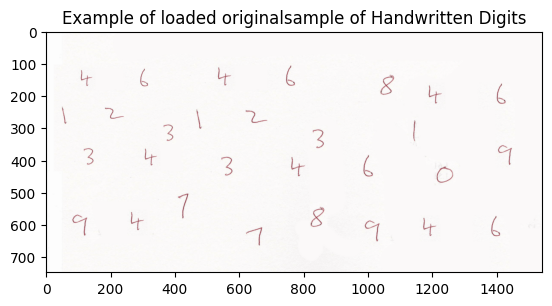

In [114]:
plt.title("Example of loaded originalsample of Handwritten Digits")
plt.imshow(cv2.imread(SAMPLE_USER_IMG))

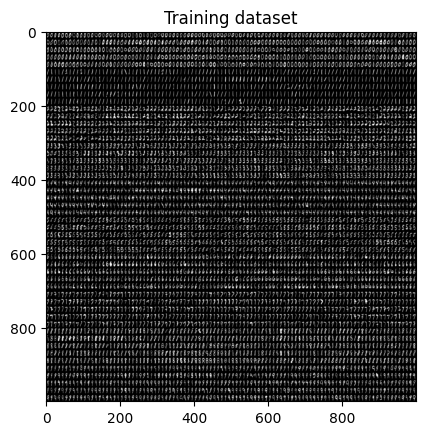

In [115]:
plt.title("Training dataset")
plt.imshow(cv2.imread(TRAIN_MNIST_IMG))

Accuracy:  0.7878787878787878
Accuracy:  0.8181818181818182


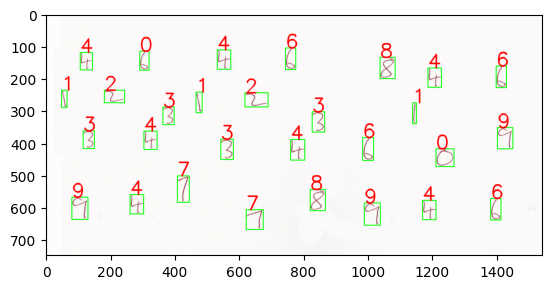

In [116]:
# Load custom handwritten digits dataset
digits, labels = load_custom_digits(TRAIN_USER_IMG)  # my handwritten dataset (better than MNIST on my handwritten digits)

# Shuffle the data for better training performance
digits, labels = sku.shuffle(digits, labels, random_state=256)

# Compute HOG descriptors for the digits images
train_digits_data = compute_hog_descriptors(digits)  # Using HOG descriptors

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = ms.train_test_split(train_digits_data, labels, test_size=0.33, random_state=42)

# Train a KNN model with k=3
model = CustomKNNModel(k=3)
model.train(X_train, y_train)
preds = model.predict(X_test)
print('Accuracy: ', skm.accuracy_score(y_test, preds))

# Train a KNN model with k=4 and process the test image
model = CustomKNNModel(k=4)
model.train(train_digits_data, labels)
process_image(SAMPLE_USER_IMG, model)

# Train a SVM model and evaluate its accuracy
model = CustomSVMModel(num_features=train_digits_data.shape[1])
model.train(X_train, y_train)
preds = model.predict(X_test)
print('Accuracy: ', skm.accuracy_score(y_test, preds))


**Executing the program will generate 2 output files:**
- This is the original image with digit boxes and the identified number placed above handwritten.

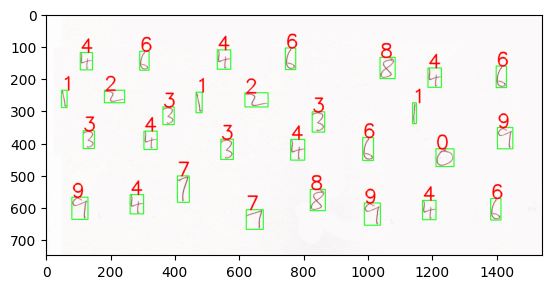

In [117]:
# Train a SVM model and process the test image
model = CustomSVMModel(num_features=train_digits_data.shape[1])
model.train(train_digits_data, labels)
process_image(SAMPLE_USER_IMG, model)

- This is a final plain image with just the recognized numbers printed.

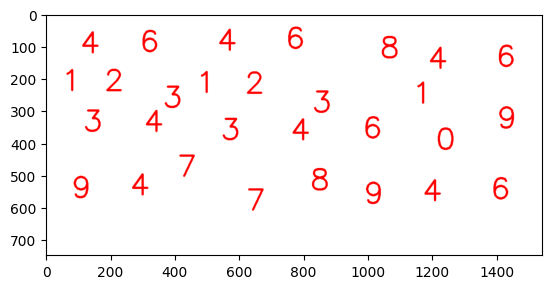

In [118]:
img_final = cv2.imread("final_digits.png")
plt.imshow(img_final)

### **Conclusion:**

Handwritten digit recognition is a challenging task, but through the integration of image processing techniques and machine learning algorithms, this project demonstrates significant progress in addressing this problem. By leveraging custom datasets and advanced feature extraction methods like HOG descriptors, the project achieves accurate digit recognition results. Overall, the project contributes to the advancement of handwritten digit recognition technology, with potential applications in various fields.

### **References:**
- Pavitrakumar. (n.d.). GitHub - pavitrakumar78/Street-View-House-Numbers-SVHN-Detection-and-Classification-using-CNN: A 2-CNN pipeline to do both detection (using bounding box regression) and classification of numbers on SVHN dataset. GitHub. https://github.com/pavitrakumar78/Street-View-House-Numbers-SVHN-Detection-and-Classification-using-CNN
- Digit Recognizer | Kaggle. (n.d.). https://www.kaggle.com/competitions/digit-recognizer
- Pavitrakumar. (n.d.-a). GitHub - pavitrakumar78/Python-Custom-Digit-Recognition: Using OpenCV in python to recognize digits in a scanned page of handwritten digits. GitHub. https://github.com/pavitrakumar78/Python-Custom-Digit-Recognition
- Team, D., Team, D., & Team, D. (2021, March 14). Deep Learning Project – Handwritten Digit Recognition using Python. DataFlair. https://data-flair.training/blogs/python-deep-learning-project-handwritten-digit-recognition/
